In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# run this cell if running remotely

!pip install transformers==4.3.3
!pip install stop_words
!pip install symspellpy
!pip install language_detector
!pip install cached_property
!pip install sentencepiece
!pip install config
!pip install umap
!pip install sentence-transformers==0.4.1
!pip install nltk
import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

from google.colab import drive
drive.mount('/content/drive')

import tensorflow, sentence_transformers, transformers
tensorflow.__version__, sentence_transformers.__version__, transformers.__version__

root_path = "/content/drive/MyDrive/SCHOOL/PhD/Code/context-encoder-v2"
import sys, os
import config

config.root_path = os.path.abspath(root_path)
sys.path.insert(0, config.root_path)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.9 MB 4.9 MB/s 
     |████████████████████████████████| 880 kB 88.1 MB/s 
     |████████████████████████████████| 3.3 MB 82.2 MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.53-py3-none-any.whl size=895260 sha256=054df14fdc673bafbc272d500e75574d9df17e5c66024c9b079950fddbb9a7c7
  Stored in directory: /root/.cache/pip/wheels/82/ab/9b/c15899bf659ba74f623ac776e861cf2eb8608c1825ddec66a4
Successfully built sacremoses
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for stop-words: filename=stop_words-2018.7.23-py3-none-any.whl size=32910 sha256=eec3f585a493baa024c4e58059c6169dba970efcf7552ce10ed99bb344573438
  Stored in directory: /root/.cache/pip/wheels/eb/03/0d/3bd31c983789aeb0b4d5e2ca48590288d9db1586cf5f225062
Successfully built stop-words
Looking in indexes: https://pypi.

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


Mounted at /content/drive


In [3]:
import tensorflow, sentence_transformers, transformers
tensorflow.__version__, sentence_transformers.__version__, transformers.__version__

('2.9.2', '0.4.1', '4.3.3')

In [ ]:
# run this cell if working locally
import sys, os
import config

config.root_path = os.path.abspath(os.path.join(os.getcwd(), "..", ".."))
sys.path.insert(0, config.root_path)

In [4]:
import tensorflow as tf

from src.encoders.context_encoder_ldabert_2 import ContextEncoderSimple
from src.dataset.ldabert_2 import LDABERT2Dataset

from tensorflow.python import keras
import toml
import json
import pandas as pd
import numpy as np
from utils.experiments import get_experiments_json, get_experiments, save_results

Downloading:   0%|          | 0.00/630 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/409 [00:00<?, ?B/s]

## Experiment

In [5]:
experiments_config = get_experiments_json('ldabert2_simple_test')
experiments_config_df = pd.DataFrame.from_dict(experiments_config)
experiments_config_df

,bert_type,dataset_type,final_dropout,dense_neurons,max_sentence_length,gamma,pct_data,augment_pct,bert_trainable,epochs
0,ldabert,clinical,0.5,128,128,15,1,1,False,1000
1,ldabert,wiki,0.5,128,128,15,1,1,False,1000
2,ldabert,fiction,0.5,128,128,15,1,1,False,1000


In [6]:
experiments_config_df.to_csv(r'../models/experiment.csv', header=None, index=None, sep=' ', mode='a')

In [7]:
def get_random_hash(k):
  import random, string
  x = ''.join(random.choices(string.ascii_letters + string.digits, k=k))
  return x

In [ ]:
# all
for experiment in experiments_config[2:3]:
    dataset_type = experiment['dataset_type']
    final_dropout = experiment['final_dropout']
    dense_neurons = experiment['dense_neurons']
    pct_data = experiment['pct_data']
    augment_pct = experiment['augment_pct']
    gamma = experiment['gamma']
    max_sentence_length = experiment['max_sentence_length']
    bert_trainable = experiment['bert_trainable']
    epochs = 200 # experiment['epochs']
    BATCH_SIZE = 32
    print("params:", experiment)
    random_hash = get_random_hash(5)
    experiment['epochs'] = epochs

    # init model
    print("initializing model...")
    model = ContextEncoderSimple(final_dropout=final_dropout,
                            dense_neurons=dense_neurons,
                          gamma=gamma,
                          max_sentence_length=max_sentence_length,
                           bert_trainable=bert_trainable)

    # print("number of params: ", sum([np.prod(keras.get_value(w).shape) for w in model.trainable_weights]))

    # init training dataset
    print("initializing dataset...")
    dataset = LDABERT2Dataset(dataset_type=dataset_type,
                            pct_data=pct_data,
                          max_seq_length=max_sentence_length,
                            max_segment_length=300,
                            augment_pct=augment_pct,
                            split="train",
                        artificial_segments=True)

    # process training dataset
    print("processing dataset...")
    sentences, tokenized_sentences, labels = dataset.process()

    vectors_filename = '{}_{}_as-{}_msl-{}.pkl'.format(dataset.pct_data, dataset.augment_pct, dataset.artificial_segments, dataset.max_segment_length)

    saved_vectors, saved_labels, saved_sentences, saved_tokenized_sentences = dataset.get_saved_vectors("train", dataset.dataset_type, vectors_filename)

    if len(saved_vectors) == 0:
        saved_vectors, saved_labels, saved_sentences, saved_tokenized_sentences = dataset.create_vectors("train", dataset.dataset_type, vectors_filename)

    left_input, mid_input, right_input = dataset.format_sentences_tri_input_plus(saved_tokenized_sentences)
    lda_left_input, lda_mid_input, lda_right_input = dataset.format_sentences_tri_input(saved_vectors)


    # init testing dataset
    print("initializing testing dataset...")
    testing_dataset = LDABERT2Dataset(dataset_type=dataset_type,
                            pct_data=0.25,
                          max_seq_length=512,
                            max_segment_length=300,
                            augment_pct=0,
                            split="test",
                        artificial_segments=False)

    # process testing dataset
    print("processing testing dataset...")
    testing_sentences, testing_tokenized_sentences, testing_labels = testing_dataset.process()

    vectors_filename = '{}_{}_testing_data.pkl'.format(testing_dataset.pct_data, testing_dataset.augment_pct)

    testing_saved_vectors, testing_saved_labels, testing_saved_sentences, testing_saved_tokenized_sentences = testing_dataset.get_saved_vectors("test", testing_dataset.dataset_type, vectors_filename)

    if len(testing_saved_vectors) == 0:
        testing_saved_vectors, testing_saved_labels, testing_saved_sentences, testing_saved_tokenized_sentences = testing_dataset.create_vectors("test", testing_dataset.dataset_type, vectors_filename)

    testing_left_input, testing_mid_input, testing_right_input = testing_dataset.format_sentences_tri_input_plus(testing_saved_tokenized_sentences)
    testing_lda_left_input, testing_lda_mid_input, testing_lda_right_input = testing_dataset.format_sentences_tri_input(testing_saved_vectors)

    # get class weight
    neg, pos = np.bincount(labels.flatten())
    initial_bias = np.log([pos/neg])

    total=len(labels)
    weight_for_0 = (1 / neg)*(total)/2.0
    weight_for_1 = (1 / pos)*(total)/2.0

    class_weight = {0: weight_for_0, 1: weight_for_1}
    print("class weight", class_weight)

    # create checkpoint path
    checkpoint_filepath = '{}/models/LDABERT2/simple/{}-{}-{}-pct-{}-aug_{}/no-finetune/checkpoint.ckpt'.format(
                            config.root_path,
                            dataset.dataset_type,
                            len(saved_sentences),
                            dataset.pct_data,
                            dataset.augment_pct,
                            random_hash)

    # # continue training
    # random_hash = 'nH75d'
    # checkpoint_filepath = '{}/models/LDABERT2/simple/clinical-15051-1-pct-1-aug_{}/no-finetune/checkpoint.ckpt'.format(
    #     config.root_path,
    #     random_hash
    # )

    # model_filepath = "/".join(checkpoint_filepath.split("/")[:-1]) + "/model.h5"
    print(checkpoint_filepath)

    # get callbacks ready.
    model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
        filepath=checkpoint_filepath,
        save_weights_only=True,
        monitor='val_accuracy',
        save_best_only=True,
        mode="auto",
        save_freq="epoch")

    early_stopping = tf.keras.callbacks.EarlyStopping(
        monitor='val_accuracy',
        verbose=1,
        patience=10,
        mode='max',
        restore_best_weights=True)

    log_path = '{}/models/LDABERT2/simple/{}-{}-{}-pct-{}-aug_{}/no-finetune/training.log'.format(
                            config.root_path,
                            dataset.dataset_type,
                            len(saved_sentences),
                            dataset.pct_data,
                            dataset.augment_pct,
                            random_hash)

    csv_logger = tf.keras.callbacks.CSVLogger(log_path, separator=",", append=False)

    callbacks = [
    #     early_stopping,
        model_checkpoint_callback,
        csv_logger
    ]

    # compiling model
    print("compiling the model...")
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
                  loss=tf.keras.losses.BinaryCrossentropy(),
                  metrics=[
                      keras.metrics.BinaryAccuracy(name='accuracy')
                  ])

    try:
        model.load_weights(checkpoint_filepath)
        print("model loaded.")
    except:
        print("No checkpoint available.")

    print("starting the training process...")
    history = model.fit([
                            left_input, mid_input, right_input,
                            lda_left_input, lda_mid_input, lda_right_input
                        ],
                        tf.convert_to_tensor(saved_labels),
                        validation_data=([
                            testing_left_input, testing_mid_input, testing_right_input,
                            testing_lda_left_input, testing_lda_mid_input, testing_lda_right_input
                        ], tf.convert_to_tensor(testing_saved_labels)),
                        epochs=epochs,
                        # validation_split=0.25,
                        batch_size=BATCH_SIZE,
                        verbose=1,
                        class_weight=class_weight,
                        callbacks=callbacks)

    # assigning history to experiment object for saving.
    experiment["history"] = history.history
    experiment["hash"] = random_hash

    print("saving results...")
    save_results(experiment)

params: {'bert_type': 'ldabert', 'dataset_type': 'fiction', 'final_dropout': 0.5, 'dense_neurons': 128, 'max_sentence_length': 128, 'gamma': 15, 'pct_data': 1, 'augment_pct': 1, 'bert_trainable': False, 'epochs': 1000}
initializing model...


Downloading:   0%|          | 0.00/625 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/438M [00:00<?, ?B/s]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['embeddings.position_ids']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


initializing dataset...
processing dataset...
artificial segments True
artificial segments True
initializing testing dataset...
processing testing dataset...
artificial segments False
class weight {0: 0.5279945456636383, 1: 9.43031103286385}
/content/drive/MyDrive/SCHOOL/PhD/Code/context-encoder-v2/models/LDABERT2/simple/fiction-64277-1-pct-1-aug_CKV1e/no-finetune/checkpoint.ckpt
compiling the model...
No checkpoint available.
starting the training process...
Epoch 1/200


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


2009/2009 [==============================] - ETA: 0s - loss: 0.3660 - accuracy: 0.8166

2009/2009 [==============================] - 417s 192ms/step - loss: 0.3660 - accuracy: 0.8166 - val_loss: 0.3759 - val_accuracy: 0.8571
Epoch 2/200
2009/2009 [==============================] - 382s 190ms/step - loss: 0.2727 - accuracy: 0.8693 - val_loss: 0.2867 - val_accuracy: 0.8788
Epoch 3/200
2009/2009 [==============================] - 382s 190ms/step - loss: 0.2420 - accuracy: 0.8849 - val_loss: 0.2716 - val_accuracy: 0.8901
Epoch 4/200
2009/2009 [==============================] - 382s 190ms/step - loss: 0.2308 - accuracy: 0.8939 - val_loss: 0.3038 - val_accuracy: 0.8959
Epoch 5/200
2009/2009 [==============================] - 382s 190ms/step - loss: 0.2197 - accuracy: 0.8979 - val_loss: 0.1633 - val_accuracy: 0.9011
Epoch 6/200
2009/2009 [==============================] - 382s 190ms/step - loss: 0.2100 - accuracy: 0.9041 - val_loss: 0.1529 - val_accuracy: 0.9065
Epoch 7/200
2009/2009 [==============================] - 382s 190ms/step - loss: 0.2036 - accuracy: 0.9084 - val_loss:

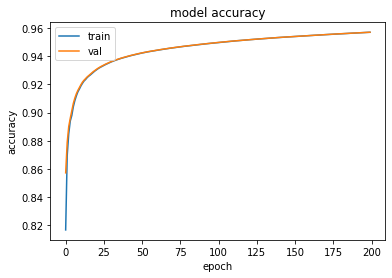

In [ ]:
from matplotlib import pyplot as plt
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()